IMPORT

In [0]:
import os
from PIL import Image
import torchvision
from torchvision import transforms
from random import randint
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Function
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.data import DataLoader
import numpy as np
import logging

logging.raiseExceptions = False

# time finished task function
def donetime(start=None, partial=False):
  if start is not None:
    if ((time.time() - start)/60) < 60:
      if partial is True:
        print('DONE (time {:4.2f} m)'.format((time.time() - start)/60))
      else:
        print('LOG TIMe {:4.2f} m'.format((time.time() - start)/60))
    else:
      if partial is True:
        print('DONE (time {:4.2f} h)'.format((time.time() - start)/3600))
      else:
        print('LOG TIME {:4.2f} h'.format((time.time() - start)/3600))
  else:
    print('\nDONE')
  return

# simple status bar 
def statusBar(actual, finish, vanish=False): #no other prints!
  print(end="\r", flush=True)
  print('[ ', end = '') 
  for i in range(actual):
    print('###', end = '')
  if actual != (finish -1):
    print('#>-', end = '')
  for i in range(finish - actual - 2):
    print('---', end = '')
  print(' ]', end = '')
  if actual == (finish -1) and vanish == True:
    print(end="\r", flush=True)
  return

donetime()


DONE


download GIT REPOSITORY and define PARAMETERS

In [0]:
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git

photo_dir = 'Homework3-PACS/PACS/photo'
art_dir = 'Homework3-PACS/PACS/art_painting'

DEVICE = 'cuda'
NUM_CLASSES = 7
BATCH_SIZE = 128
MOMENTUM = 0.9    
WEIGHT_DECAY = 5e-5  
GAMMA = 0.1        
LOG_FREQUENCY = 20

# parameters to tune

LR = 0.001
NUM_EPOCHS = 10
STEP_SIZE = 6
ALPHA = 0.5
ALPHA_type = 'linear_ascendant'
#ALPHA_type = 'linear_discendant'

donetime()


DONE


define TRANSFORMATIONS, prepare DATASETS and DATALOADERS

In [0]:
photo_transform = transforms.Compose([transforms.Resize(256),     
                                      transforms.CenterCrop(224),  
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization 
                                    ])
art_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization 
                                    ])

photo_dataset = torchvision.datasets.ImageFolder(photo_dir, transform=photo_transform)
print('Train dataset imported ({} photo)'.format(len(photo_dataset)))
art_dataset = torchvision.datasets.ImageFolder(art_dir, transform=art_transform)
print('Test dataset imported ({} art)\n'.format(len(art_dataset)))

show_some = 0
if show_some is not 0:
  print('Some photo form the trainset:')
  for i in range(show_some):
    im, label = photo_dataset[randint(0, len(photo_dataset))]
    plt.figure()
    plt.title(photo_dataset.classes[label])
    plt.imshow(im.permute(1, 2, 0))
    plt.show()
  print('\nSome art form the testset:')
  for i in range(show_some):
    im, label = art_dataset[randint(0, len(art_dataset))]
    plt.figure()
    plt.title(art_dataset.classes[label])
    plt.imshow(im.permute(1, 2, 0))
    plt.show()


photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

donetime()

Train dataset imported (1670 photo)
Test dataset imported (2048 art)


DONE


build DANN from ALEXNET structure

In [0]:
try:
  from torch.hub import load_state_dict_from_url
except ImportError:
  from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']
model_urls = { 'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', }


class AlexNet(nn.Module):

  def __init__(self, num_classes=1000):
    super(AlexNet, self).__init__()
    #CONVOLUTIONAL LAYERS
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    #CLASS CLASSIFIER 
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, num_classes), #last fully connected layer: predict class
    )
    #DOMAIN DISCRIMINATOR
    self.discriminator = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, 2), #last fully connected layer: predict domain
    )

  def forward(self, x, alpha=None):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = x.view(x.size(0), -1) #?
    if alpha is not None: #forward in domain discriminator
      reverse_feature = ReverseLayerF.apply(x, alpha)
      x = self.discriminator(reverse_feature)
    else: #forward in class classifier
      x = self.classifier(x)
    return x
        

def alexnet(pretrained=False, progress=True, **kwargs):
  model = AlexNet(**kwargs)
  if pretrained:
    state_dict = load_state_dict_from_url(model_urls['alexnet'], progress=progress)
    model.load_state_dict(state_dict, strict=False)
  return model

class ReverseLayerF(Function):

  @staticmethod
  def forward(ctx, x, alpha):
    ctx.alpha = alpha
    return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
    output = grad_output.neg() * ctx.alpha
    return output, None

donetime()


DONE


IMAGENET pretraining adapted on DANN

In [0]:
def prepareDANN():
  net = alexnet(pretrained=True)

  net.discriminator[1].weight.data = net.classifier[1].weight.data
  net.discriminator[1].bias.data = net.classifier[1].bias.data

  net.discriminator[4].weight.data = net.classifier[4].weight.data
  net.discriminator[4].bias.data = net.classifier[4].bias.data

  net.classifier[6] = nn.Linear(4096,7)
  return net

def testAccuracy(dataset,dataloader,net, without=False):
  net = net.to(DEVICE) 
  net.train(False)
  running_corrects = 0
  for images, labels in dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    # Forward Pass
    outputs = net(images)
    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataset))
  if without is False:
    print('TEST ACCURACY (with DANN adaptation): {}'.format(accuracy))
  else:
    print('TEST ACCURACY (without DANN adaptation): {}'.format(accuracy))
  return accuracy

def get_batch(n,iterloader,dataloader):
  batch=[]
  for i in range(n):
    try:
      batch = next(iterloader)
    except :
      iterloader = iter(dataloader)
      batch = next(iterloader)
      return batch
  return batch

donetime()


DONE


TRAIN on photo, TEST on art (without adaptation)

In [0]:
'''
startTime = time.time()

DANN = prepareDANN()

criterion = nn.CrossEntropyLoss()
parameters_to_optimize = DANN.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

DANN = DANN.to(DEVICE) 
cudnn.benchmark 

current_step = 0
loss_log = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  statusBar(epoch, NUM_EPOCHS)

  # Iterate over the dataset
  for images, labels in photo_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    DANN.train()
    optimizer.zero_grad() 

    # Forward pass photo to the classifier
    classifier_outputs = DANN(images)
    classifier_loss = criterion(classifier_outputs, labels)
    classifier_loss.backward()  
      
    optimizer.step() # update weights based on accumulated gradients
    current_step += 1
     
    # Log loss
    loss_log.append((current_step, classifier_loss.item()))
    #if current_step % LOG_FREQUENCY == 0:
      #print('CLASSIFIER: (Step {}) Loss {}'.format(current_step, classifier_loss.item()))

  # Step the scheduler
  scheduler.step() 

  DANN = DANN.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  DANN.train(False) # Set Network to evaluation mode

  running_corrects = 0
  
print('\n\n(step, classifier_loss)')
a = []
for tupl in loss_log:
  print('({}, {})'.format(tupl[0], tupl[1]))
  a.append(tupl[1])
print('')
plt.title('without DANN adaptation')
plt.plot(a, label='classifier loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.grid()
plt.legend()
plt.show()

testAccuracy(art_dataset, art_dataloader, DANN)

donetime(startTime)
'''

"\nstartTime = time.time()\n\nDANN = prepareDANN()\n\ncriterion = nn.CrossEntropyLoss()\nparameters_to_optimize = DANN.parameters()\noptimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\nscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)\n\nDANN = DANN.to(DEVICE) \ncudnn.benchmark \n\ncurrent_step = 0\nloss_log = []\n\n# Start iterating over the epochs\nfor epoch in range(NUM_EPOCHS):\n  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))\n  statusBar(epoch, NUM_EPOCHS)\n\n  # Iterate over the dataset\n  for images, labels in photo_dataloader:\n\n    images = images.to(DEVICE)\n    labels = labels.to(DEVICE)\n\n    DANN.train()\n    optimizer.zero_grad() \n\n    # Forward pass photo to the classifier\n    classifier_outputs = DANN(images)\n    classifier_loss = criterion(classifier_outputs, labels)\n    classifier_loss.backward()  \n      \n    optimizer.step() # update wei

train with ADAPTATION, test on art 

In [0]:
'''
startTime = time.time()



DANN = prepareDANN()

data_target_iter = iter(art_dataloader)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = DANN.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

DANN = DANN.to(DEVICE) 
cudnn.benchmark 

current_step = 0
log_tuplevector = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):

  # paper formula
  #p = float((current_step) / ((len(photo_dataset) / BATCH_SIZE) * NUM_EPOCHS))
  #ALPHA = 2. / (1. + np.exp(-10 * p)) - 1 

  #print('Starting epoch {}/{}, LR = {}, ALPHA = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), ALPHA))
  statusBar(epoch, NUM_EPOCHS)

  # Iterate over the dataset
  for images, labels in photo_dataloader:

    
    
    
    if ALPHA_type is 'flat_0.1':
      ALPHA = 0.1
    if ALPHA_type is 'flat_0.5':
      ALPHA = 0.5
    if ALPHA_type is 'linear_ascendant':
      ALPHA = float((current_step) / ((len(photo_dataset) / BATCH_SIZE) * NUM_EPOCHS))
    if ALPHA_type is 'linear_discendant':
      ALPHA = float(((-1) * (current_step)) / ((len(photo_dataset) / BATCH_SIZE) * NUM_EPOCHS))


    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    DANN.train()
    optimizer.zero_grad() 

    # Forward pass photo to the classifier
    classifier_outputs = DANN(images)
    classifier_loss = criterion(classifier_outputs, labels)
    classifier_loss.backward()  

    # Forward pass photo to the discriminator
    discriminator_photo_outputs = DANN(images, ALPHA)
    photo_targets = torch.zeros(labels.size(0), dtype=torch.int64).to(DEVICE)
    discriminator_photo_loss = criterion(discriminator_photo_outputs, photo_targets)
    discriminator_photo_loss.backward()

    # Load art
    art_images, art_labels = get_batch(BATCH_SIZE, data_target_iter, art_dataloader)
    art_images = art_images.to(DEVICE)
    art_labels = art_labels.to(DEVICE)
    
    # forward pass target to gd
    discriminator_art_outputs = DANN(art_images, ALPHA)
    art_labels = torch.ones(labels.size(0) , dtype=torch.int64).to(DEVICE)
    discriminator_art_loss = criterion(discriminator_art_outputs,art_labels)
    discriminator_art_loss.backward()
      
    optimizer.step() # update weights based on accumulated gradients
    current_step += 1
     
    # Log loss
    log_tuplevector.append((current_step, classifier_loss.item(), discriminator_photo_loss.item(), discriminator_art_loss.item(), ALPHA))
    #if current_step % LOG_FREQUENCY == 0:
      #print('CLASSIFIER: (Step {}) Loss {}'.format(current_step, classifier_loss.item()))
      #print('DISCRIMINATON photo: (Step {}) Loss {}'.format(current_step, discriminator_photo_loss.item()))
      #print('DISCRIMINATOR art: (Step {}) Loss {}'.format(current_step, discriminator_art_loss.item()))

  # Step the scheduler
  scheduler.step() 

  DANN = DANN.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  DANN.train(False) # Set Network to evaluation mode

  running_corrects = 0

print('\n\n(step, classifier_loss, discriminator_photo_loss, discriminator_art_loss, ALPHA)')
a = []
b = []
c = []
for tupl in log_tuplevector:
  print('({}, {}, {}, {}, {})'.format(tupl[0], tupl[1], tupl[2], tupl[3], tupl[4]))
  a.append(tupl[1])
  b.append(tupl[2])
  c.append(tupl[3])
print('')
plt.title('with DANN adaptation')
plt.plot(a, label='classifier loss')
plt.plot(b, label='discriminator loss (photo)')
plt.plot(c, label='discriminator loss (art)')
plt.ylabel('loss')
plt.xlabel('step')
plt.grid()
plt.legend()
plt.show()

testAccuracy(art_dataset, art_dataloader, DANN)
    
donetime(startTime)
'''

"\nstartTime = time.time()\n\n\n\nDANN = prepareDANN()\n\ndata_target_iter = iter(art_dataloader)\ncriterion = nn.CrossEntropyLoss()\nparameters_to_optimize = DANN.parameters()\noptimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\nscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)\n\nDANN = DANN.to(DEVICE) \ncudnn.benchmark \n\ncurrent_step = 0\nlog_tuplevector = []\n\n# Start iterating over the epochs\nfor epoch in range(NUM_EPOCHS):\n\n  # paper formula\n  #p = float((current_step) / ((len(photo_dataset) / BATCH_SIZE) * NUM_EPOCHS))\n  #ALPHA = 2. / (1. + np.exp(-10 * p)) - 1 \n\n  #print('Starting epoch {}/{}, LR = {}, ALPHA = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), ALPHA))\n  statusBar(epoch, NUM_EPOCHS)\n\n  # Iterate over the dataset\n  for images, labels in photo_dataloader:\n\n    \n    \n    \n    if ALPHA_type is 'flat_0.1':\n      ALPHA = 0.1\n    if ALPHA_type is 'flat_0.5':\n      AL

CYCLED procedure

[10/20] LR: 0.0005
TEST ACCURACY (without DANN adaptation): 0.5
[11/20] LR: 0.0005, ALPHA: linear


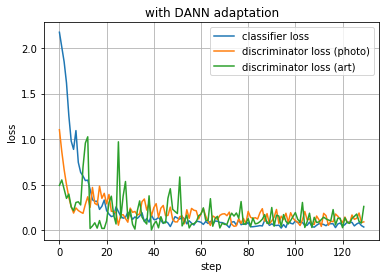

TEST ACCURACY (with DANN adaptation): 0.486328125
[12/20] LR: 0.0005, ALPHA: flat 0.1


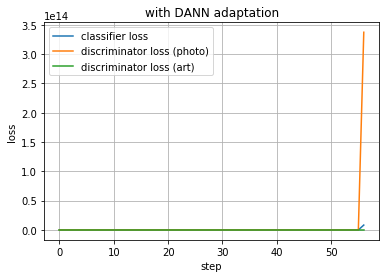

TEST ACCURACY (with DANN adaptation): 0.18505859375
[13/20] LR: 0.0005, ALPHA: flat 0.5


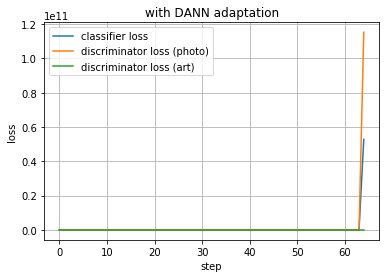

TEST ACCURACY (with DANN adaptation): 0.18505859375
[14/20] LR: 0.0005, ALPHA: flat 1


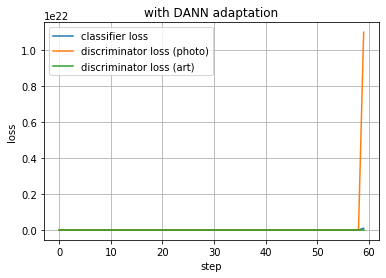

TEST ACCURACY (with DANN adaptation): 0.18505859375
DONE (time 12.47 m)
[15/20] LR: 0.001
TEST ACCURACY (without DANN adaptation): 0.466796875
[16/20] LR: 0.001, ALPHA: linear


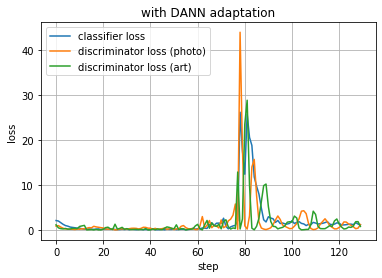

TEST ACCURACY (with DANN adaptation): 0.29052734375
[17/20] LR: 0.001, ALPHA: flat 0.1


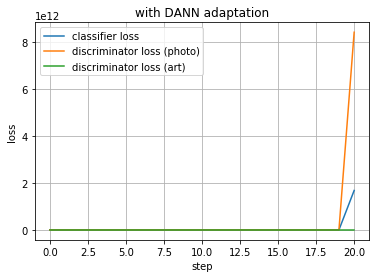

TEST ACCURACY (with DANN adaptation): 0.18505859375
[18/20] LR: 0.001, ALPHA: flat 0.5


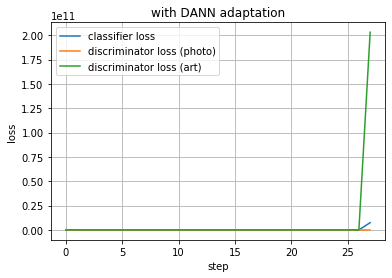

TEST ACCURACY (with DANN adaptation): 0.18505859375
[19/20] LR: 0.001, ALPHA: flat 1


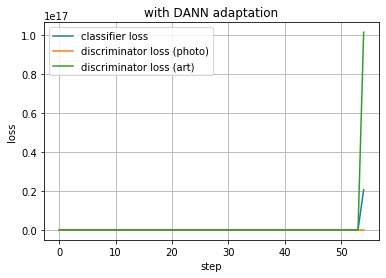

TEST ACCURACY (with DANN adaptation): 0.18505859375
DONE (time 25.25 m)


In [0]:
startTime = time.time()

LRs = [0.00005, 0.0001, 0.0005, 0.001]
NUM_EPOCHSsSTEP_SIZEs = [(10, 6)]
ALPHAs = ['linear', 'flat 0.1', 'flat 0.5', 'flat 1']
count_iteration = 0 #
main_log = []

start_iteration = 10

for LRiter in LRs:
  for NUM_EPOCHSiter, STEP_SIZEiter in NUM_EPOCHSsSTEP_SIZEs:
    for ALPHAiter in ALPHAs:
      if count_iteration >= start_iteration:

        ### TEST VANILLA only first alpha
        if ALPHAiter == ALPHAs[0]:
          print('[{}/{}] LR: {}'.format(count_iteration, len(LRs) * len(NUM_EPOCHSsSTEP_SIZEs) * (len(ALPHAs) + 1 ),  LRiter))

          DANN = prepareDANN()

          criterion = nn.CrossEntropyLoss()
          parameters_to_optimize = DANN.parameters()
          optimizer = optim.SGD(parameters_to_optimize, lr=LRiter, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
          scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZEiter, gamma=GAMMA)

          DANN = DANN.to(DEVICE) 
          cudnn.benchmark 

          current_step = 0
          loss_log = []

          # Start iterating over the epochs
          for epoch in range(NUM_EPOCHSiter):
            #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
            statusBar(epoch, NUM_EPOCHSiter, vanish=True)

            # Iterate over the dataset
            for images, labels in photo_dataloader:

              images = images.to(DEVICE)
              labels = labels.to(DEVICE)

              DANN.train()
              optimizer.zero_grad() 

              # Forward pass photo to the classifier
              classifier_outputs = DANN(images)
              classifier_loss = criterion(classifier_outputs, labels)
              classifier_loss.backward()  
                
              optimizer.step() # update weights based on accumulated gradients
              current_step += 1
              
              # Log loss
              loss_log.append((current_step, classifier_loss.item()))
              #if current_step % LOG_FREQUENCY == 0:
                #print('CLASSIFIER: (Step {}) Loss {}'.format(current_step, classifier_loss.item()))

            # Step the scheduler
            scheduler.step() 

            DANN = DANN.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
            DANN.train(False) # Set Network to evaluation mode

            running_corrects = 0
            
          a = []
          for tupl in loss_log:
            a.append(tupl[1])
          #print('\nLR {}, NUM_EPOCHS {}, STEP_SIZE {}, ALPHA {}'.format(LRiter, NUM_EPOCHSiter, STEP_SIZEiter, ALPHAiter))
          #plt.title('without DANN adaptation')
          #plt.plot(a, label='classifier loss')
          #plt.ylabel('loss')
          #plt.xlabel('step')
          #plt.grid()
          #plt.legend()
          #plt.show()

          score = testAccuracy(art_dataset, art_dataloader, DANN, without=True)
          main_log.append( (count_iteration, LRiter, NUM_EPOCHSiter, STEP_SIZEiter, 'none', score) )

          count_iteration += 1

          #donetime(startTime, partial=True)
        
        ### TEST DANN
        
        print('[{}/{}] LR: {}, ALPHA: {}'.format(count_iteration, len(LRs) * len(NUM_EPOCHSsSTEP_SIZEs) * (len(ALPHAs) + 1), LRiter, ALPHAiter))

        DANN = prepareDANN()

        criterion = nn.CrossEntropyLoss()
        parameters_to_optimize = DANN.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=LRiter, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZEiter, gamma=GAMMA)

        DANN = DANN.to(DEVICE) 
        cudnn.benchmark 

        current_step = 0
        log_tuplevector = []
        max_step = (len(photo_dataset) / BATCH_SIZE) * NUM_EPOCHSiter

        # Start iterating over the epochs
        for epoch in range(NUM_EPOCHSiter):
          
          data_target_iter = iter(art_dataloader)

          # paper formula
          #p = float((current_step) / ((len(photo_dataset) / BATCH_SIZE) * NUM_EPOCHS))
          #ALPHA = 2. / (1. + np.exp(-10 * p)) - 1 

          #print('Starting epoch {}/{}, LR = {}, ALPHA = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), ALPHA))
          statusBar(epoch, NUM_EPOCHSiter, vanish=True)

          # Iterate over the dataset
          for images, labels in photo_dataloader:
            
            if ALPHAiter is 'flat 0.1':
              ALPHA = 0.1
            if ALPHAiter is 'flat 0.3':
              ALPHA = 0.3
            if ALPHAiter is 'flat 0.5':
              ALPHA = 0.5
            if ALPHAiter is 'flat 1':
              ALPHA = 1
            if ALPHAiter is 'linear':
              ALPHA = float(current_step / max_step)
            if ALPHAiter is 'hyperbolic':
              ALPHA = float(((-1) * (max_step)/(current_step + 1) + max_step) / max_step)
            if ALPHA > 1:
              print("WARNING ERROR: ALPHA > 1")

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            DANN.train()
            optimizer.zero_grad() 

            # Forward pass photo to the classifier
            classifier_outputs = DANN(images)
            classifier_loss = criterion(classifier_outputs, labels)
            classifier_loss.backward()  

            # Forward pass photo to the discriminator
            discriminator_photo_outputs = DANN(images, ALPHA)
            photo_targets = torch.zeros(labels.size(0), dtype=torch.int64).to(DEVICE)
            discriminator_photo_loss = criterion(discriminator_photo_outputs, photo_targets)
            discriminator_photo_loss.backward()

            # Load art
            #art_images, art_labels = get_batch(BATCH_SIZE, data_target_iter, art_dataloader)
            art_images, art_labels = next(data_target_iter)
            art_images = art_images.to(DEVICE)
            art_labels = art_labels.to(DEVICE)
            
            # forward pass target to gd
            discriminator_art_outputs = DANN(art_images, ALPHA)
            art_labels = torch.ones(labels.size(0) , dtype=torch.int64).to(DEVICE)
            discriminator_art_loss = criterion(discriminator_art_outputs,art_labels)
            discriminator_art_loss.backward()
              
            optimizer.step() # update weights based on accumulated gradients
            current_step += 1
            
            # Log loss
            log_tuplevector.append((current_step, classifier_loss.item(), discriminator_photo_loss.item(), discriminator_art_loss.item(), ALPHA))
            #if current_step % LOG_FREQUENCY == 0:
              #print('CLASSIFIER: (Step {}) Loss {}'.format(current_step, classifier_loss.item()))
              #print('DISCRIMINATON photo: (Step {}) Loss {}'.format(current_step, discriminator_photo_loss.item()))
              #print('DISCRIMINATOR art: (Step {}) Loss {}'.format(current_step, discriminator_art_loss.item()))

          # Step the scheduler
          scheduler.step() 

          DANN = DANN.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
          DANN.train(False) # Set Network to evaluation mode

          running_corrects = 0

        a = []
        b = []
        c = []
        for tupl in log_tuplevector:
          a.append(tupl[1])
          b.append(tupl[2])
          c.append(tupl[3])
        #print('\nLR {}, NUM_EPOCHS {}, STEP_SIZE {}, ALPHA {}'.format(LRiter, NUM_EPOCHSiter, STEP_SIZEiter, ALPHAiter))
        plt.title('with DANN adaptation')
        plt.plot(a, label='classifier loss')
        plt.plot(b, label='discriminator loss (photo)')
        plt.plot(c, label='discriminator loss (art)')
        plt.ylabel('loss')
        plt.xlabel('step')
        plt.grid()
        plt.legend()
        plt.show()

        score = testAccuracy(art_dataset, art_dataloader, DANN)
        main_log.append( (count_iteration, LRiter, NUM_EPOCHSiter, STEP_SIZEiter, ALPHA, score) )

        count_iteration += 1

        #donetime(startTime, partial=True)
      else:
        count_iteration += 1
        if ALPHAiter == ALPHAs[0]:
          count_iteration += 1
    if count_iteration > start_iteration:
      donetime(startTime, partial=True)

RESULTS analysis

In [0]:
import matplotlib.pyplot as plt
import numpy as np

results = [] # (counter, LR, NUM_EPOCHS, STEP_SIZE, ALPHA, accuracy)
support1 = []
support2 = []
support3 = []

#LRs = [0.0005, 0.001, 0.005]
#NUM_EPOCHSsSTEP_SIZEs = [(10, 6), (30, 10), (50, 20)]
#ALPHAs = ['linearly ascendant', 'flat 0.1', 'flat 0.3']

results.append( (0,  0.0005, 10, 6,  'none',                 0.5054) ) 
results.append( (1,  0.0005, 10, 6,  'linear',   0.4883) ) 
results.append( (2,  0.0005, 10, 6,  'flat 0.1',             0.4868) ) 
results.append( (3,  0.0005, 10, 6,  'flat 0.3',             0.4736) ) 

results.append( (4,  0.0005, 30, 10,  'none',                0.4775) ) 
results.append( (5,  0.0005, 30, 10,  'linear',              0.1812) ) 
results.append( (6,  0.0005, 30, 10,  'flat 0.1',            0.1851) ) 
results.append( (7,  0.0005, 30, 10,  'flat 0.3',            0.4126) )

results.append( (8,  0.0005, 50, 20,  'none',                0.4521) ) 
results.append( (9,  0.0005, 50, 20,  'linear',              0.1655) ) 
results.append( (10, 0.0005, 50, 20,  'flat 0.1',            0.1440) ) 
results.append( (11, 0.0005, 50, 20,  'flat 0.3',            0.2603) )

results.append( (12, 0.001, 10, 6,  'none',                  0.4995) ) 
results.append( (13, 0.001, 10, 6,  'linear',                 0.1851) ) 
results.append( (14, 0.001, 10, 6,  'flat 0.1',              0.1851) ) 
results.append( (15, 0.001, 10, 6,  'flat 0.3',              0.2080) ) 

results.append( (16, 0.001, 30, 10,  'none',                 0.5010) ) 
results.append( (17, 0.001, 30, 10,  'linear',               0.2251) ) 
results.append( (18, 0.001, 30, 10,  'flat 0.1',             0.1943) ) 
results.append( (19, 0.001, 30, 10,  'flat 0.3',             0.2373) )

results.append( (20, 0.001, 50, 20,  'none',                0.4810) ) 
results.append( (21, 0.001, 50, 20,  'linear',              0.2192) ) 
results.append( (22, 0.001, 50, 20,  'flat 0.1',            0.1851) ) 
results.append( (23, 0.001, 50, 20,  'flat 0.3',            0.1851) )

results.append( (24, 0.005, 10, 6,  'none',                 0.4629) ) 
results.append( (25, 0.005, 10, 6,  'linear',               0.1851) ) 
results.append( (26, 0.005, 10, 6,  'flat 0.1',             0.1851) ) 
results.append( (27, 0.005, 10, 6,  'flat 0.3',             0.1851) ) 

results.append( (28, 0.005, 30, 10,  'none',                0.4971) ) 
results.append( (29, 0.005, 30, 10,  'linear',              0.1851) ) 
results.append( (30, 0.005, 30, 10,  'flat 0.1',            0.1851) ) 
results.append( (31, 0.005, 30, 10,  'flat 0.3',            0.1851) )

results.append( (32, 0.005, 50, 20,  'none',                0.4834) ) 
results.append( (33, 0.005, 50, 20,  'linear',              0.1851) ) 
results.append( (34, 0.005, 50, 20,  'flat 0.1',            0.1851) ) 
results.append( (35, 0.005, 50, 20,  'flat 0.3',            0.1851) )

for counter, LR, NUM_EPOCHS, STEP_SIZE, ALPHA, accuracy in results:
  support1.append(counter)
  support2.append(accuracy)


plt.barh(support1, support2)
plt.grid()
plt.show()